In [248]:
# Loading Packages
import pandas as pd
import numpy as np
import datetime
import scipy.stats as scs
from dateutil.relativedelta import relativedelta

import scipy.stats as scs
from scipy.stats import norm
import math
from statsmodels.formula.api import ols
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import distance

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import pickle
from utils import *


%load_ext autoreload
%autoreload 2

sns.set(style='white', context='notebook', palette='deep')
plt.style.use('ggplot')
pd.set_option('display.max_columns', 360)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
train = pd.read_csv('kc_house_data_train.csv')

In [147]:
# Save the 'Id' column
train_ID = train['id']

# lets seperate Target variable 
target = train['price']

# Drop the 'Id' column since it's unnecessary for the prediction process.
train.drop(['id','Unnamed: 0'], axis = 1, inplace = True)


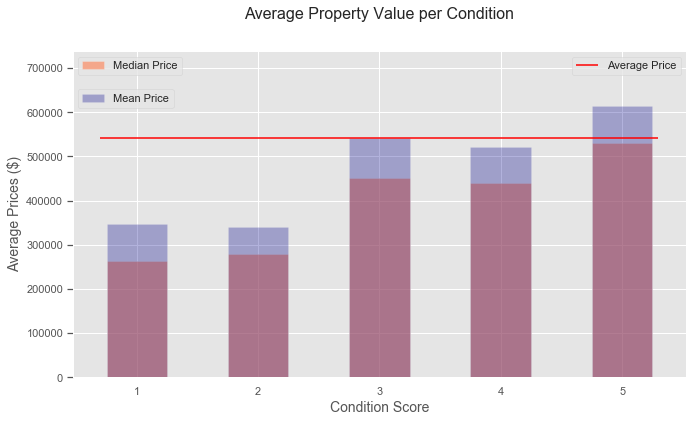

In [148]:
mean = train.groupby("condition")["price"].mean()
median = train.groupby("condition")["price"].median()
mean_data = train.price.mean()
score = np.arange(1,6)
fig, ax = plt.subplots(figsize=(11,6))
ax2 = ax.twinx() #set ax2 on same x axis as ax
ax3 = ax.twinx() #same as above, for hline
width = 0.5
ax.bar(x=score, height=median, width=width,
       label="Median Price", color="coral", alpha=0.6)
ax2.bar(x=score, height=mean, width=width,
        label="Mean Price", color="darkblue", alpha=0.3)
ax3.hlines(mean_data, .7 ,5.3, colors="red", label="Average Price")
ax.set_ylim(0,1.2*mean.max())
ax2.set_ylim(0,1.2*mean.max())
ax3.set_ylim(0,1.2*mean.max())
ax2.yaxis.set_visible(False) #hide the 2nd axis
ax3.yaxis.set_visible(False)
ax.legend(bbox_to_anchor=(0,0,1,1), loc="upper left")
ax2.legend(bbox_to_anchor=(0,-.1,1,1), loc="upper left")
ax3.legend(bbox_to_anchor=(0,0,1,1), loc="upper right")
ax.set_ylabel("Average Prices ($)", size=14)
ax.set_xlabel("Condition Score", size=14)
plt.title("Average Property Value per Condition", size=16, y=1.08)
plt.legend()
plt.savefig('cond_score.png')
plt.show();


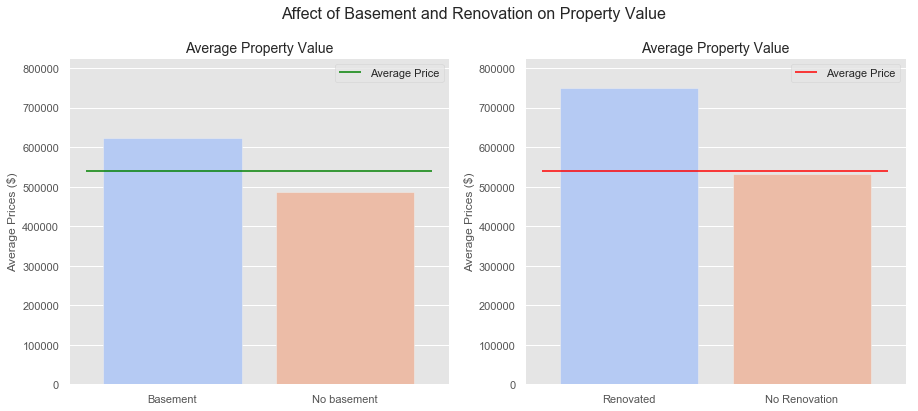

In [149]:
basement = train[(train["sqft_basement"] != 0)]
basement_mean = basement.price.mean()
no_basement = train[(train["sqft_basement"] == 0)]
no_basement_mean = no_basement.price.mean()

#mean values to plot
renovated = train[(train["yr_renovated"] > 0)]
renovated_mean = renovated.price.mean()
not_renovated = train[(train["yr_renovated"] == 0)]
not_renovated_mean = not_renovated.price.mean()

#prepare plot labels
label_basement = ["Basement", "No basement"]
values_basement = [basement_mean, no_basement_mean]
label_renovation = ["Renovated", "No Renovation"]
values_renovation = [renovated_mean, not_renovated_mean]

# Barplots
fig, ax = plt.subplots(1, 2, figsize=(15,6))

sns.barplot(ax=ax[0], x=label_basement, y=values_basement, palette="coolwarm")
sns.barplot(ax=ax[1], x=label_renovation, y=values_renovation, palette="coolwarm")

train_mean_price = train.price.mean()

ax[0].hlines(train_mean_price, -.5 ,1.5, colors="green", label="Average Price") #plot average price horizontal line
ax[1].hlines(train_mean_price, -.5 ,1.5, colors="red", label="Average Price") #plot average price horizontal line

#prettify graph
ax[0].set_ylabel("Average Prices ($)", size=12)
ax[0].set_title("Average Property Value", size=14)
ax[0].set_ylim(0,1.1*renovated_mean)
ax[0].legend()

ax[1].set_ylabel("Average Prices ($)", size=12)
ax[1].set_title("Average Property Value", size=14, )
ax[1].set_ylim(0,1.1*renovated_mean)
ax[1].legend()

plt.suptitle("Affect of Basement and Renovation on Property Value", size=16, y=1)

#uncomment below to export image
# plt.savefig("images/basement_renovation_value.png",bbox_inches = "tight")
plt.savefig('basement_renov.png')
plt.show();


## Statistical Tests

In [150]:
# H0 : There is no significant difference in price between Houses with basement and without basement
# HA : There is significant difference  in price between Houses with basement and without basement

# Select the appropriate test and calculate the test statistic and P-values.
# We dont have STD of the population - will go to T-test
# T test  - Difference of 2 means (m1-m2)

# Evaluate the test statistic agains the critical value.
# Let check it with function diff_two_means

In [151]:
# Creating 2 Subsets houses with Basement and Houses Without Basement
with_basement = train[train.sqft_basement==0]
no_basement = train[train.sqft_basement!=0]

In [152]:
diff_two_means(no_basement, with_basement, threshold = 95)


        We reject the null Hypotesys because based one statistical test two groups sample means difference 
        is = 21.73, which gets in rejection area defined by critical values 1.96 and -1.96.
        


In [153]:
# H0 : There is no significant difference in price between Houses with renovation and without renovation
# HA : There is significant difference in price between Houses with renovation and without renovation

# Select the appropriate test and calculate the test statistic and P-values.
# We dont have STD of the population - will go to T-test
# T test  - Difference of 2 means (m1-m2)

# Evaluate the test statistic agains the critical value.
# Let check it with function diff_two_means

In [154]:
# Creating two subsets:
never_renov = train[train.yr_renovated==0]
renov = train[train.yr_renovated!=0]

In [155]:
diff_two_means(renov, never_renov, 95)


        We reject the null Hypotesys because based one statistical test two groups sample means difference 
        is = 9.4, which gets in rejection area defined by critical values 1.96 and -1.96.
        


In [156]:
# H0: There is no statistically significant difference in avg price between the houses with differ conditions
# HA: There is statistically significant difference in avg price between the houses with differ conditions

# As we have more then 2 groups  and we trying to compare avg price per each group - will have to use ANOVA
#          𝐻0  :  𝜇1  =  𝜇2  =  𝜇n
#          𝐻𝑎  :  𝜇1  !=  𝜇2  !=  𝜇n

# ANOVA - Analysis of Variance  (Perfoming F-test)
# ANOVA will tell us if at least 1 of the groups not like another one

In [159]:
anova_test(train[['condition','price']],'price', 95)

NameError: name 'anova_test' is not defined

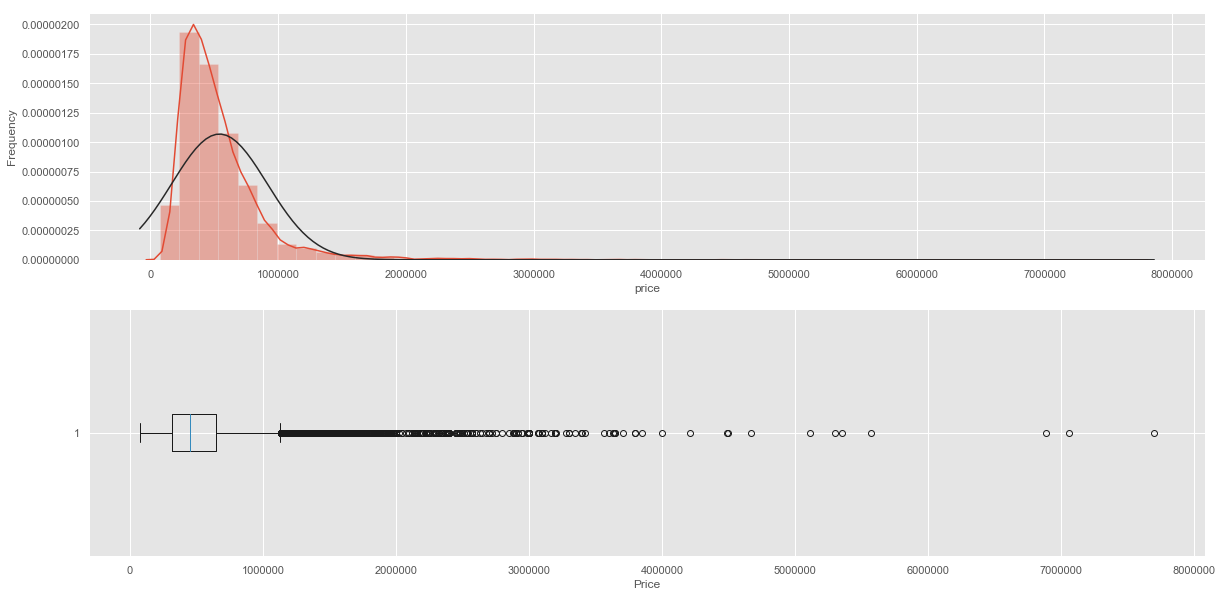

In [160]:
# Plot Histogram and boxplot
fig = plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.ylabel('Frequency')
sns.distplot(target, fit = norm)
plt.subplot(2,1,2)
plt.boxplot(target, vert = False)
plt.xlabel('Price')
plt.show()

# Additionally create data visualizations to determine if there are any relationships between your features and your target variables.
# Features Selection

In [161]:
# Lets create Correlation Matrix Heatmap with function features_corr_matrix(df)
# Find index of feature columns with correlation greater than 0.70

In [162]:
# f = train.columns[~(train.columns == 'price')]

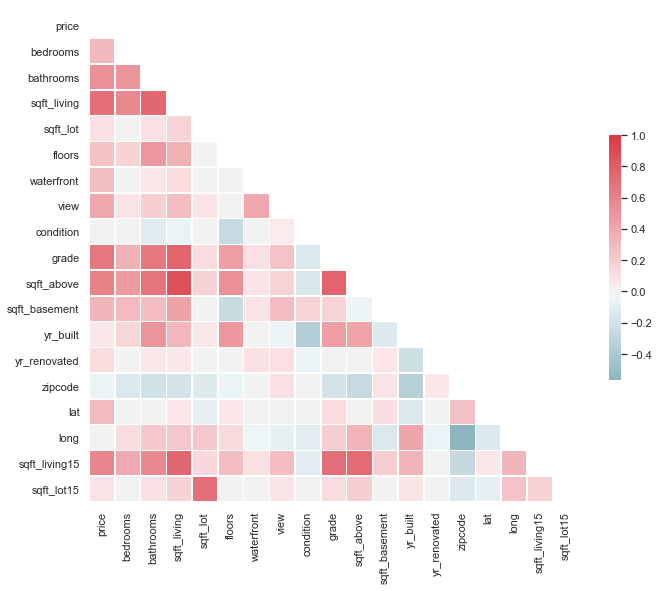

Based on threshold 0.7 , sugested featrures to drop - ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15']


In [163]:
features_corr_matrix(train, 0.7)

## Based on corr test we can exclude ['sqft_above', 'sqft_living15', 'sqft_lot15']

In [164]:
train[['sqft_living','sqft_above', 'sqft_living15', 'sqft_lot15']].corr()

,sqft_living,sqft_above,sqft_living15,sqft_lot15
sqft_living,1.000000,0.876696,0.755066,0.179570
sqft_above,0.876696,1.000000,0.731077,0.193874
sqft_living15,0.755066,0.731077,1.000000,0.178533
sqft_lot15,0.179570,0.193874,0.178533,1.000000


In [165]:
train.drop(columns = ['sqft_above', 'sqft_living15', 'sqft_lot15'], inplace=True)

## Step 3: Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

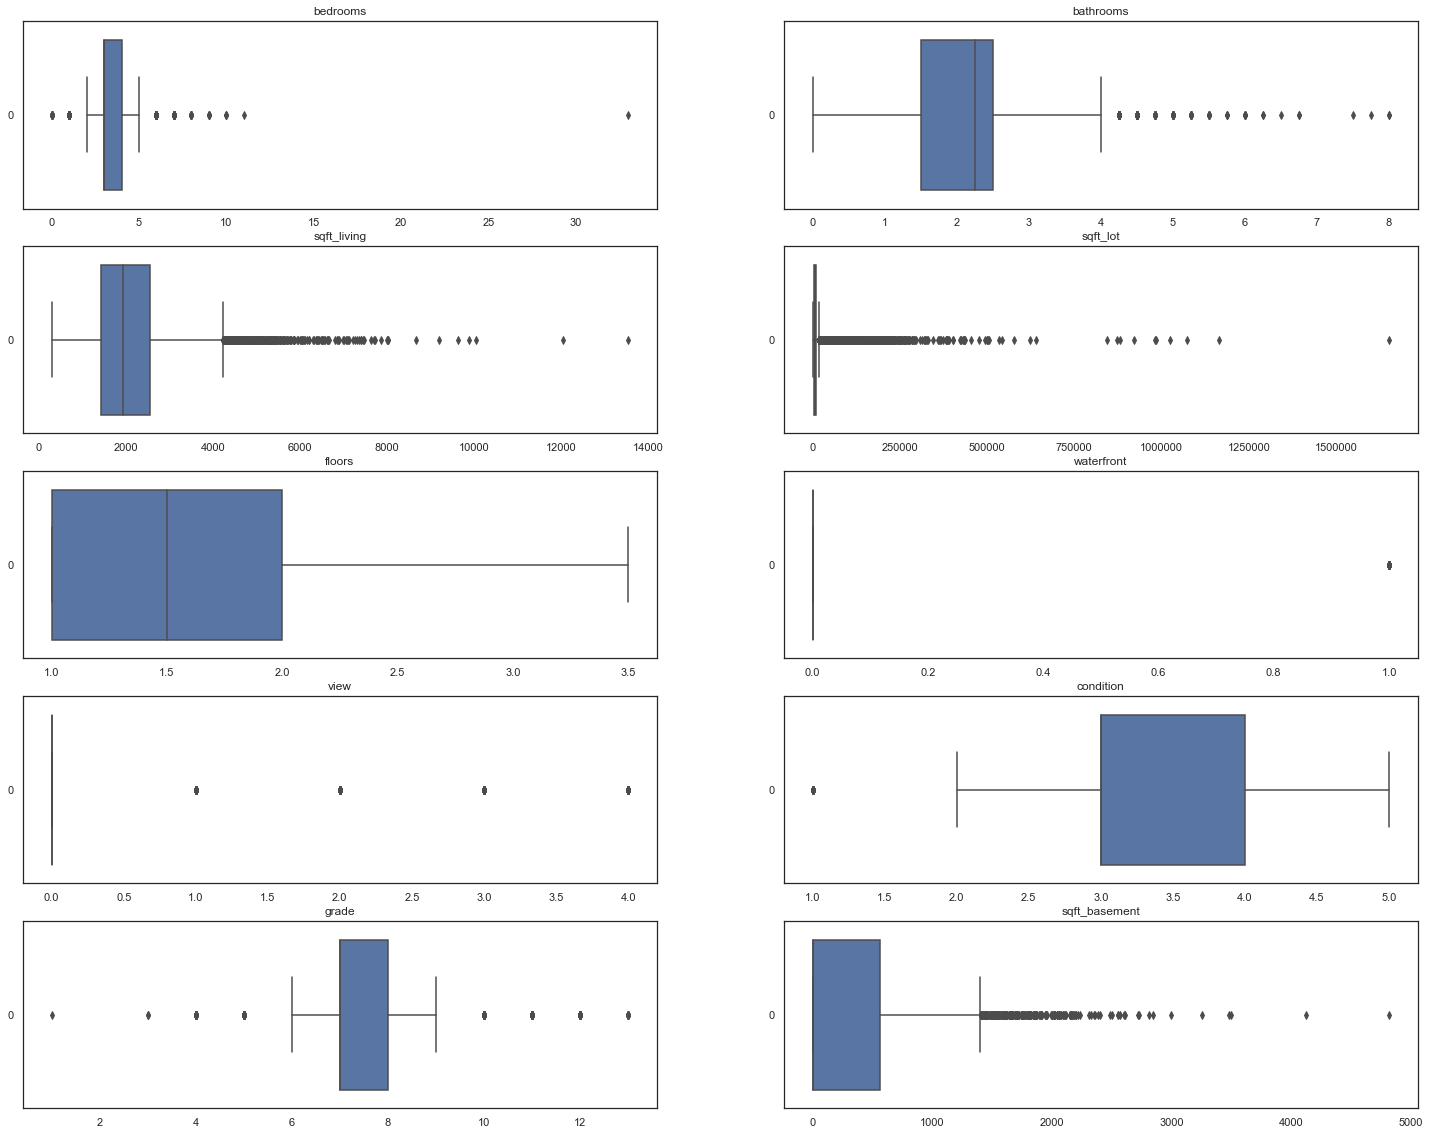

In [166]:
# Lets take a look at our independent variables
box_plots(train[[ 'bedrooms','bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement']])

In [167]:
# As we can see variables as 'conditions', 'waterfront', 'view', 'grade' can be treated as CATEGORICAL VARIABLES

In [168]:
categorical_variables = ['condition', 'view', 'floors', 'grade',  'waterfront', 'zipcode']
contin_variables = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement']

In [169]:
# Lets Explore more our variable with continious values and clean up them: 

<Figure size 1800x1440 with 0 Axes>

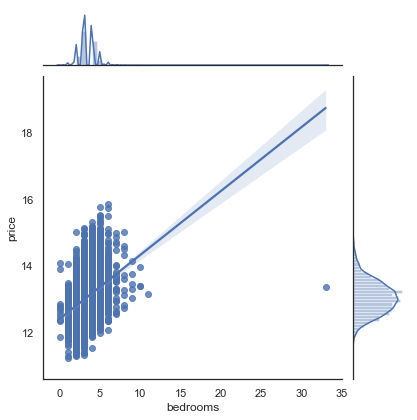

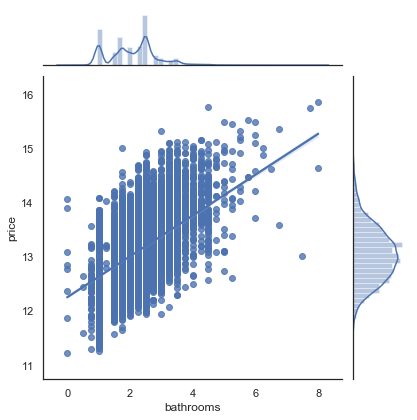

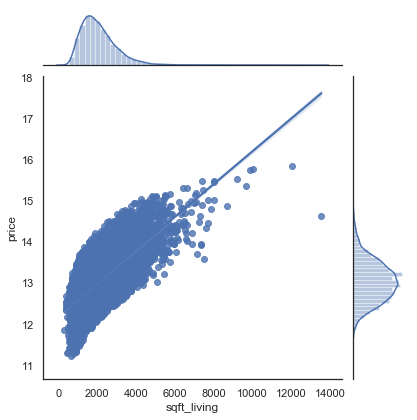

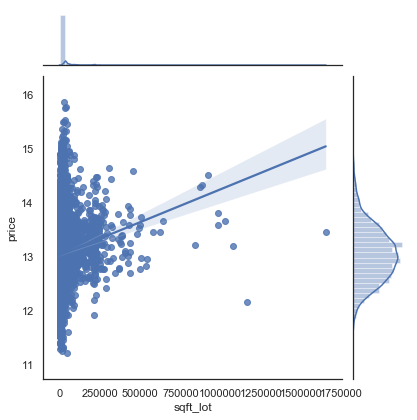

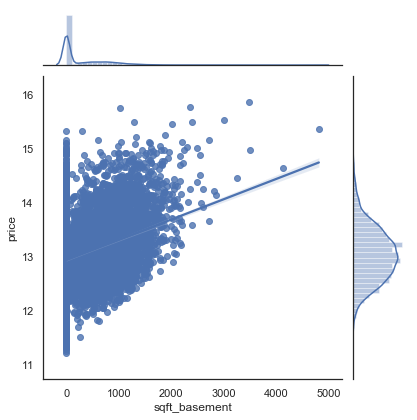

In [170]:
relationship(train[contin_variables], np.log(target))

# There is 0 values in bedrooms and bathrooms ! Also outliers in bedrooms Lets clean up this problem with function map_bad_bath

In [171]:
train = train.apply(map_bed_bath, axis = 1)

<Figure size 1800x1440 with 0 Axes>

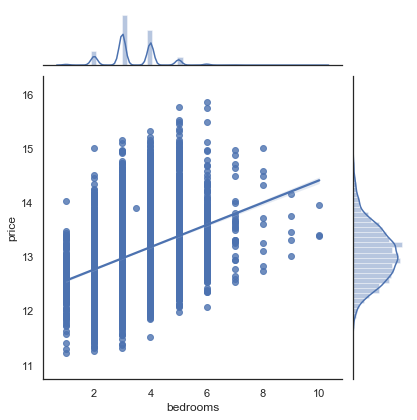

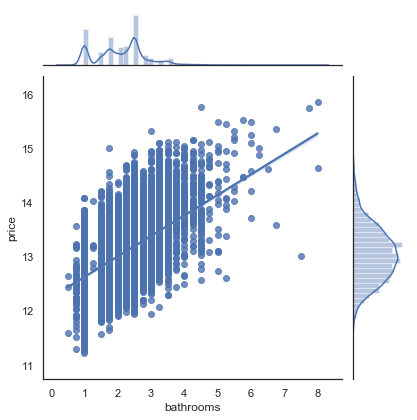

In [172]:
relationship(train[['bedrooms','bathrooms']], np.log(target))

## Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

In [173]:
# Lets Create new feature - distance from the house to downtown by using function distance_to_dwntwn in miles

In [174]:
train['dist_dntwn'] = train.apply(distance_to_dwntwn, axis = 1) 
train = train.drop(columns = ['lat','long'])

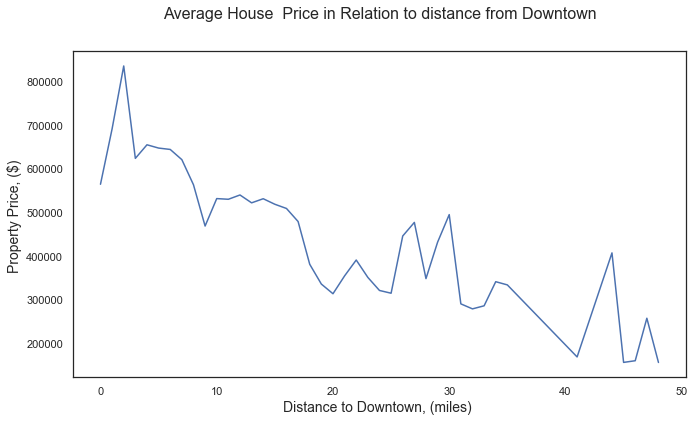

In [175]:
# Plot Avg House price compare how far place located from Downtown of the city

dist_dntwn = train.groupby('dist_dntwn')['price'].mean()

fig = plt.figure(figsize=(11,6))

sns.lineplot(x = dist_dntwn.index, y =dist_dntwn.values)
plt.ylabel("Property Price, ($) ", size=14)
plt.xlabel("Distance to Downtown, (miles) ", size=14)
plt.title("Average House  Price in Relation to distance from Downtown", size=16, y=1.08)
plt.savefig('dist_dntwn.png')
plt.show()


In [176]:
train = train.drop(columns='price')

<Figure size 1800x1440 with 0 Axes>

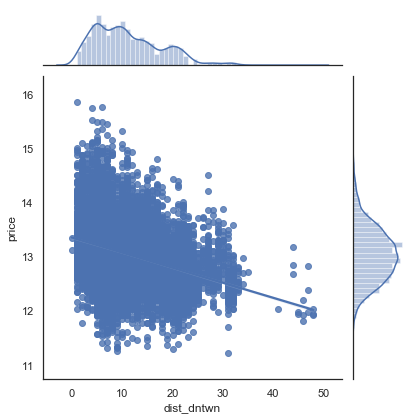

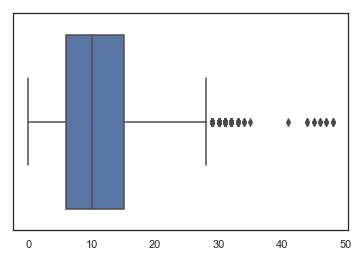

In [177]:
relationship(train[['dist_dntwn']], np.log(target))
sns.boxplot(train[['dist_dntwn']], orient='h', color = 'b')

In [178]:
features1 = [x for x in train.columns if x not in ['date']]

In [179]:
# Lets check how our model perform now based on modified F:
train_test_valid(train[features1], target)

Training: RMSE 198331 vs. Testing: RMSE 196830
Perfomance : 1 %


### 4.1) Identify a categorical variable in the data set and create dummy columns.

In [180]:
categorical_variables

['condition', 'view', 'floors', 'grade', 'waterfront', 'zipcode']

In [181]:
# Lets create catigorical data for variable sqft_basement as its is present or not in the house
train['basement'] = train['sqft_basement'].map(lambda x : 1 if x != 0 else 0)

# Lets Add it to our list of categorical variables
categorical_variables = categorical_variables+['basement']

# converting categoricav variables to dummies with function to_dummies. 
train = to_dummies(train,categorical_variables)

In [182]:
features2 = [x for x in train.columns if x not in ['date']]

In [183]:
# Lets check how our model perform now based on modified F:
train_test_valid(train[features2], target)

Training: RMSE 152105 vs. Testing: RMSE 145793
Perfomance : 4 %


## RMSE went little bit down from 196171 to 149778.

In [184]:
# transforming date when house was sold to daytime format
#train['date'] = train['date'].map(lambda x: datetime.datetime.strptime(x,'%Y%m%dT%H%M%S'))

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column?

In [185]:
#train['yr_built'] = pd.to_datetime(train['yr_built'], format='%Y')
#train['years_old'] = train['yr_built'].map(lambda x : relativedelta(datetime.datetime.now(), x).years)

In [186]:
train['years_old'] = train['yr_built'].map(lambda x : 2021-x)
train['abs_years_old'] = train['years_old'].map(lambda x: abs(x-round(train['years_old'].mean())))

# Lets convert our 'yr_renovated' column into datetime format with function format_yr_renov(row)
# and apply this function to our train dataset

train = train.apply(format_yr_renov, axis=1)
train['yrs_from_renov'] = train['yr_renovated'].map(lambda x : relativedelta(datetime.datetime.now(), x).years)

In [187]:
features3 = [x for x in train.columns if x not in ['date','yr_built','yr_renovated']]

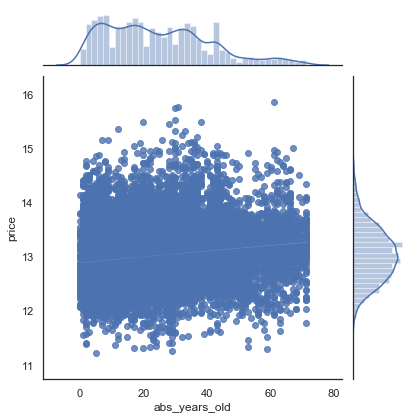

In [188]:
sns.jointplot(x=train['abs_years_old'], y = np.log(target), kind='reg')

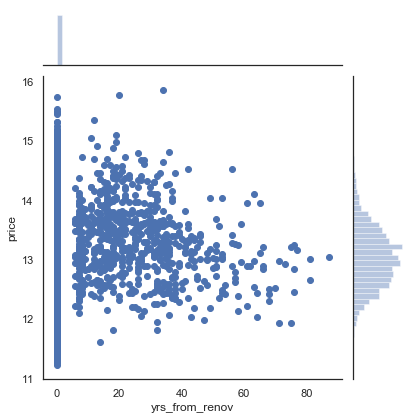

In [189]:
sns.jointplot(x=train['yrs_from_renov'], y = np.log(target))

In [190]:
# Lets chech if RMSE CHANGED
train_test_valid(train[features3], target)

Training: RMSE 152336 vs. Testing: RMSE 145867
Perfomance : 4 %


In [191]:
## RMSE didnt changed then we can drop this columns

In [192]:
train = train.drop(columns=['date','yr_built','yr_renovated'])

In [193]:
# school_rate = pd.read_csv('Niche.csv')[['zipcode','school_grade']]
# train1 = school_rate.set_index('zipcode').join(train.set_index('zipcode'), how = 'right').reset_index()

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

# Lets create poly features degrtee 2  for nonedummies features

In [194]:
fts_for_poly = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement', 'dist_dntwn', 'years_old', 'yrs_from_renov', 'abs_years_old']
df_poly2 = create_poly_df(train[fts_for_poly], 2)
not_poly_fts = [x for x in train.columns if x not in fts_for_poly]
train_poly2 = pd.merge(df_poly2, train[not_poly_fts], left_index=True, right_index=True)
train_test_valid(train_poly2, target)

Training: RMSE 133434 vs. Testing: RMSE 127371
Perfomance : 5 %


## Lets create poly features degrtee 3 for nonedummies features

In [195]:
df_poly3 = create_poly_df(train[fts_for_poly], 3)
not_poly_fts = [x for x in train.columns if x not in fts_for_poly]
train_poly3 = pd.merge(df_poly3, train[not_poly_fts], left_index=True, right_index=True)
train_test_valid(train_poly3, target)

Training: RMSE 183497 vs. Testing: RMSE 194217
Perfomance : 6 %


## Poly 4th Degree

In [196]:
df_poly4 = create_poly_df(train[fts_for_poly], 4)
not_poly_fts = [x for x in train.columns if x not in fts_for_poly]
train_poly4 = pd.merge(df_poly4, train[not_poly_fts], left_index=True, right_index=True)
train_test_valid(train_poly4, target)

Training: RMSE 188479 vs. Testing: RMSE 1561972
Perfomance : 729 %


In [197]:
len(train_poly2.columns)

149

## As we can see RMSE on Training set at poly_3 degree went signif. up and We overfiting model alot

In [198]:
# Lets Stay with the model of poly features degree 2

Training: RMSE 133447 vs. Testing: RMSE 127456
Perfomance : 4 %


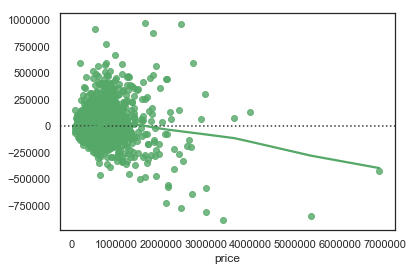

In [199]:
# Plot the residuals after fittin a linear model with POLY FEATURES DEGREE 2

scale_transform_validate(train_poly2, target, residuals= True)

Training: RMSE 122616 vs. Testing: RMSE 134256
Perfomance : 9 %


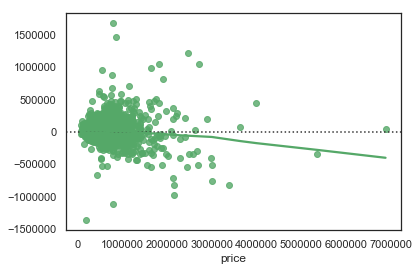

In [247]:
# Plot the residuals after fittin a linear model with POLY FEATURES DEGREE 3

scale_transform_validate(train_poly3, target, residuals=True)

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

In [45]:
# F Test Future Selection

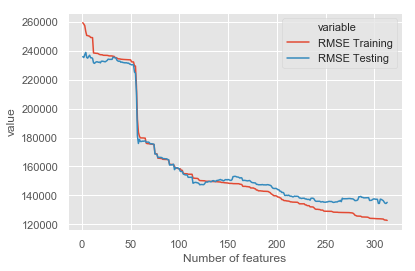

In [267]:
# Lets run feature selection function for our poly featers degree 3
# And see perfomance of RMSE based on number of features

f_test_select_vis(train_poly3, target)

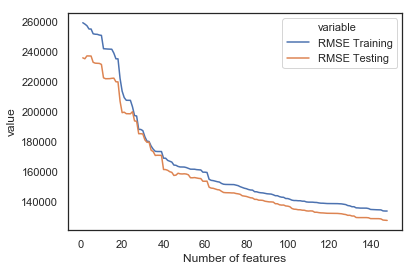

In [329]:
# Lets run feature selection function for our poly featers degree 3
# And see perfomance of RMSE based on number of features

f_test_select_vis(train_poly2, target)

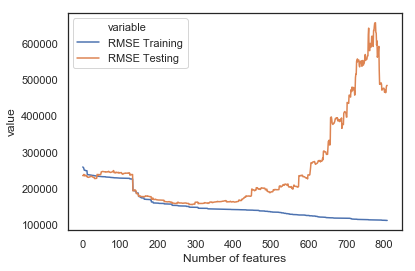

In [333]:
# Lets run feature selection function for our poly featers degree 4
# And see perfomance of RMSE based on number of features

f_test_select_vis(train_poly4, target)

In [298]:
# As we can see All features in Current training set are importent in order to achive the lowest RMSE
# with best perfomance involving Training and Testing without overfiting.

In [336]:
scale_fit_pickle_origin(train_poly2, target)

 CONGATS !!! You sucessfuly created you pickles for SCALER and MODEL


## Recursive Feature Elimination



In [270]:
def RFECV_(df, target, step = 1, cv = 5):
    
    # spliting
    X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=9,test_size=0.2)
    scaler3 = StandardScaler()
    
    # fit the scaler to the training data
    scaler3.fit(X_train)

    #transform the training data
    X_train = pd.DataFrame(data=scaler3.transform(X_train), columns=df.columns)
    
    #transform the testing dat
    X_test = pd.DataFrame(data=scaler3.transform(X_test), columns=df.columns)
    
    ols = linear_model.LinearRegression()
    
    # Create recursive feature eliminator that scores features by mean squared errors
    selector = RFECV(estimator=ols, step=step, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

    # Fit recursive feature eliminator 
    selector.fit(X_train, y_train)
    
    selected_rfe = X_train.columns[selector.support_]
    removed_rfe = X_train.columns[~selector.support_]
    
    
    #instantiate a linear regression object
    lm_rfe = LinearRegression()

    #fit the linear regression to the data
    lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

    y_rfe = lm_rfe.predict(X_train[selected_rfe])


    trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


    #print('Training Root Mean Squared Error:' , trainRFE_rmse)

    y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

    testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

    # print('Testing Root Mean Squared Error:' , testRFE_rmse)
    
    print('Training: RMSE', int(trainRFE_rmse), "vs. Testing: RMSE", int(testRFE_rmse))
    print('Perfomance : {} %'.format(round(abs((testRFE_rmse-trainRFE_rmse)/trainRFE_rmse)*100)))
    
    return 

In [271]:
RFECV_(train_poly3, target, step = 6)

Fitting estimator with 314 features.
Fitting estimator with 308 features.
Fitting estimator with 302 features.
Fitting estimator with 296 features.
Fitting estimator with 290 features.
Fitting estimator with 284 features.
Training: RMSE 122798 vs. Testing: RMSE 134565
Perfomance : 10 %
